In [1]:
import argparse
from tqdm import tqdm
import numpy as np
from detect.squeeze import reduce_precision_torch
from mydataset import cifar10_data
from model.resnet import resnet18
import torch
from attacks.auto_attack.autoattack.autoattack import AutoAttack
import os
from utlis.detection import train_detector
import torch.nn as nn
from detect.squeeze import reduce_precision_torch, median_filter_torch, non_local_means_denoising_color
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
from utlis.th_utils import th_model_eval_distance
from attacks.CW.l0_attack import CarliniL0
from attacks.CW.l2_attack import CarliniL2
from attacks.CW.li_attack import CarliniLi
from attacks.simba_pytorch.simba import SimBA

In [2]:
l1_dist = np.loadtxt('./mydataset/resnet18_PGD_l1_distance_10000examples.csv', delimiter=',')

In [3]:
l1_dist.shape

(10000, 11)

In [4]:
dist_row0=l1_dist[:,0]
dist_row2=l1_dist[:,1]

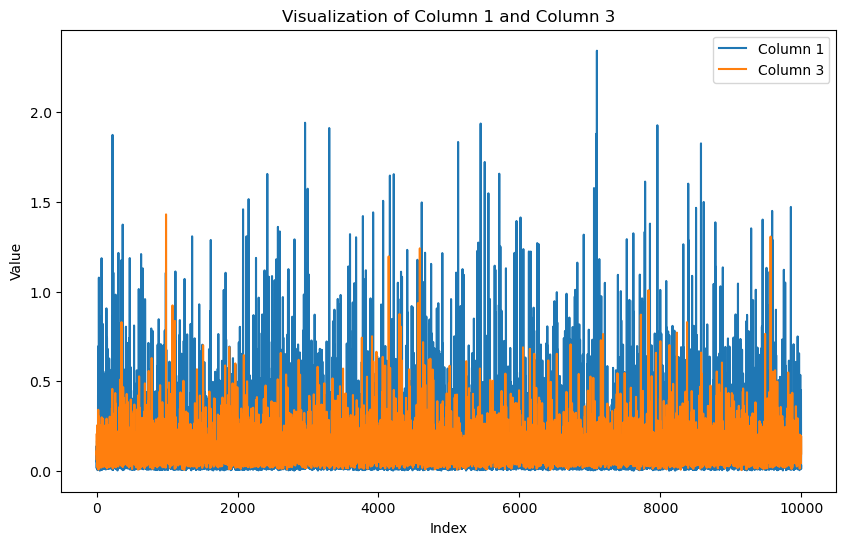

In [5]:
import matplotlib.pyplot as plt

# dist_row0 和 dist_row2 是列数据
# 绘制第一列和第三列数据的折线图
plt.figure(figsize=(10, 6))  # 设置图形大小
plt.plot(dist_row0, label='Column 1')  # 绘制第一列
plt.plot(dist_row2, label='Column 3')  # 绘制第三列



# 添加标题和图例
plt.title('Visualization of Column 1 and Column 3')
plt.xlabel('Index')  # X轴标签
plt.ylabel('Value')  # Y轴标签
plt.legend()  # 显示图例

# 显示图形
plt.show()

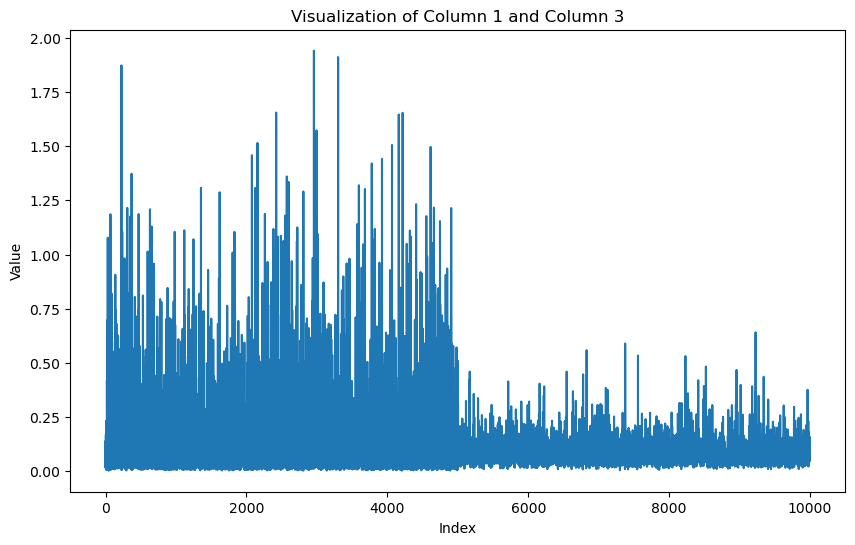

In [6]:
col_id_leg = [0]
# Selected epsilon: 0.1, 0.2, 0.3
col_id_adv = [3]
size_val=size_train=5000
x_train = np.hstack([l1_dist[:size_train, col_id] for col_id in col_id_leg + col_id_adv])
y_train = np.hstack([np.zeros(size_train * len(col_id_leg)), np.ones(size_train * len(col_id_adv))])

x_val = np.hstack([l1_dist[-size_val:, col_id] for col_id in col_id_leg + col_id_adv])
y_val = np.hstack([np.zeros(size_train * len(col_id_leg)), np.ones(size_train * len(col_id_adv))])
plt.figure(figsize=(10, 6)) 
plt.plot(x_train, label='train')  

plt.title('Visualization of Column 1 and Column 3')
plt.xlabel('Index')  
plt.ylabel('Value')  

plt.show()

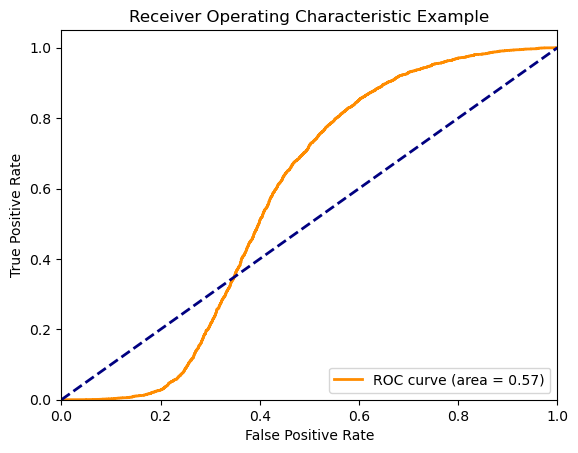

Best training accuracy: 0.6264,  检测率: 0.8566, 假阳率: 0.6040 阈值 @0.0394
ROC_AUC: 0.5714
Validation accuracy: 0.6211, 检测率: 0.8510, 假阳率: 0.6088 阈值 @0.0394
Validation ROC_AUC: 0.5671



In [7]:
train_detector(x_train, y_train, x_val, y_val)
print()

In [8]:
l1_dist_PGDinf_reduce = np.loadtxt('./mydataset/resnet18_reduce_PGD_Linf_l1distance.csv', delimiter=',')
l1_dist_PGDinf_reduce.shape

(10000, 4)

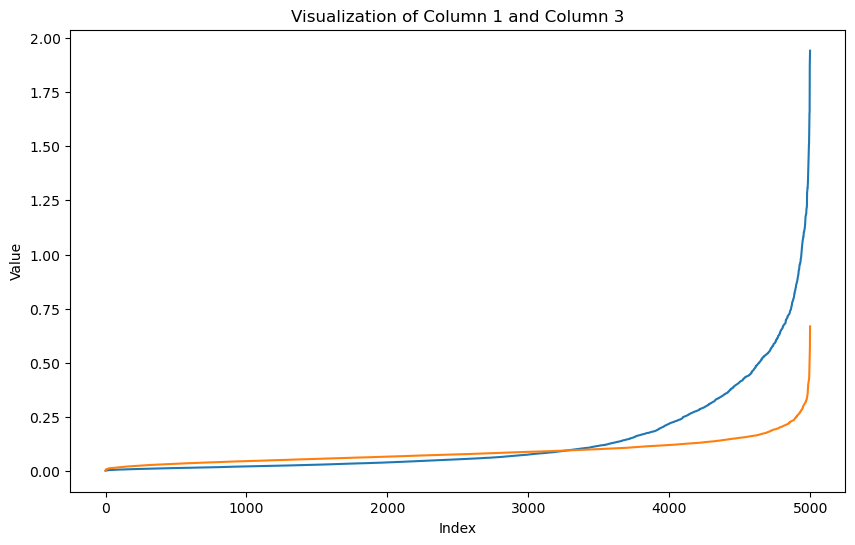

In [9]:
col_id_leg = [0]
# Selected epsilon: 0.1, 0.2, 0.3
col_id_adv = [1,2,3]
size_val=size_train=5000
x_train_PGDinf = np.hstack([l1_dist_PGDinf_reduce[:size_train, col_id] for col_id in col_id_leg + col_id_adv])
y_train_PGDinf = np.hstack([np.zeros(size_train * len(col_id_leg)), np.ones(size_train * len(col_id_adv))])

x_val_PGDinf = np.hstack([l1_dist_PGDinf_reduce[-size_val:, col_id] for col_id in col_id_leg + col_id_adv])
y_val_PGDinf = np.hstack([np.zeros(size_val * len(col_id_leg)), np.ones(size_val * len(col_id_adv))])
plt.figure(figsize=(10, 6)) 
x_CW2=sorted(list(x_train_PGDinf[:5000]))
x_CW2_adv=sorted(list(x_train_PGDinf[-5000:]))
plt.plot(x_CW2, label='adv')
plt.plot(x_CW2_adv, label='adv')

plt.title('Visualization of Column 1 and Column 3')
plt.xlabel('Index')  
plt.ylabel('Value')  

plt.show()

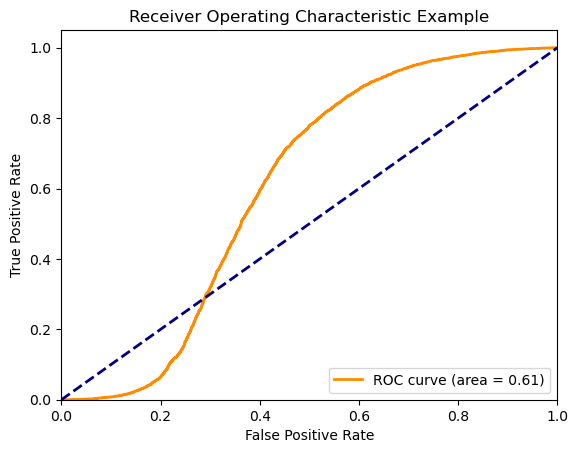

Best training accuracy: 0.7858,  检测率: 0.9635, 假阳率: 0.7476 阈值 @0.0253
ROC_AUC: 0.6062
Validation accuracy: 0.7778, 检测率: 0.9603, 假阳率: 0.7698 阈值 @0.0253
Validation ROC_AUC: 0.6047



In [10]:
train_detector(x_train_PGDinf, y_train_PGDinf, x_val_PGDinf, y_val_PGDinf)
print()

In [11]:
l1_dist_autoPGDinf_reduce = np.loadtxt('./mydataset/resnet18_reduce_autoPGD_Linf_l1distance.csv', delimiter=',')
l1_dist_autoPGDinf_reduce.shape

(10000, 4)

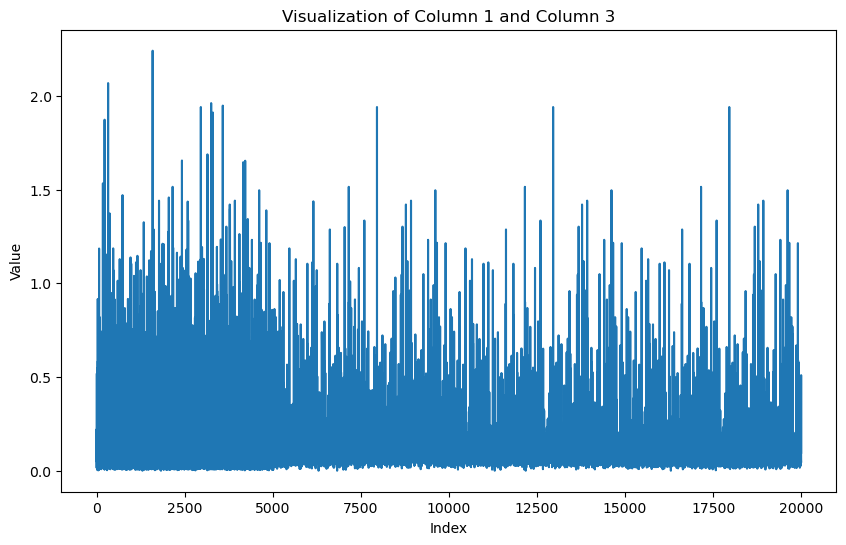

In [12]:
col_id_leg = [0]
# Selected epsilon: 0.1, 0.2, 0.3
col_id_adv = [1,2,3]
size_val=size_train=5000
x_train_autoPGDinf = np.hstack([l1_dist_autoPGDinf_reduce[:size_train, col_id] for col_id in col_id_leg + col_id_adv])
y_train_autoPGDinf = np.hstack([np.zeros(size_train * len(col_id_leg)), np.ones(size_train * len(col_id_adv))])

x_val_autoPGDinf = np.hstack([l1_dist_autoPGDinf_reduce[-size_val:, col_id] for col_id in col_id_leg + col_id_adv])
y_val_autoPGDinf = np.hstack([np.zeros(size_val * len(col_id_leg)), np.ones(size_val * len(col_id_adv))])
plt.figure(figsize=(10, 6)) 
plt.plot(x_train_autoPGDinf, label='train')  

plt.title('Visualization of Column 1 and Column 3')
plt.xlabel('Index')  
plt.ylabel('Value')  

plt.show()

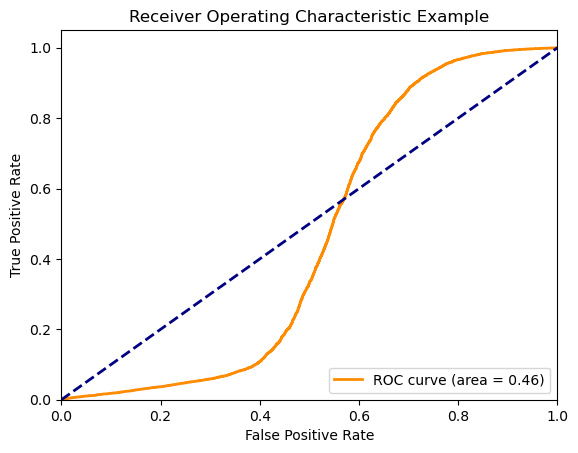

Best training accuracy: 0.7757,  检测率: 0.9770, 假阳率: 0.8284 阈值 @0.0250
ROC_AUC: 0.4569
Validation accuracy: 0.7728, 检测率: 0.9796, 假阳率: 0.8478 阈值 @0.0250
Validation ROC_AUC: 0.4438



In [13]:
train_detector(x_train_autoPGDinf, y_train_autoPGDinf, x_val_autoPGDinf, y_val_autoPGDinf)
print()

In [14]:
def plot_column_value_frequencies(data):
    """
    计算numpy数组每一列中所有值的出现频率，并为每列绘制曲线图，其中x轴是值，y轴是该值的频率。
    
    参数:
    - data: 形状为 (10000, n) 的 numpy 数组
    """
    # 获取列数
    num_columns = data.shape[1]
    
    # 设置图形大小
    plt.figure(figsize=(15, 10))
    
    # 遍历每一列
    for i in range(num_columns):
        column_data = data[:, i]
        
        # 计算每个唯一值及其出现次数
        values, counts = np.unique(column_data, return_counts=True)
        
        # 计算频率
        frequencies = counts / len(column_data)
        
        # 对值进行排序（为了绘图更直观）
        sorted_indices = np.argsort(values)
        sorted_values = values[sorted_indices]
        sorted_frequencies = frequencies[sorted_indices]
        
        # 绘制曲线图
        plt.plot(sorted_values, sorted_frequencies, label=f'Column {i+1}')
    
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Frequency of Values in Each Column')
    plt.legend(title="Columns", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
l1_dist_CW2_reduce = np.loadtxt('./mydataset/resnet18_median_filter_PGD_Linf_l1distance.csv', delimiter=',')
l1_dist_CW2_reduce.shape

(10000, 2)

In [16]:
l1_dist_CW2_reduce[0,:10]

array([4.43055058, 6.83660984])

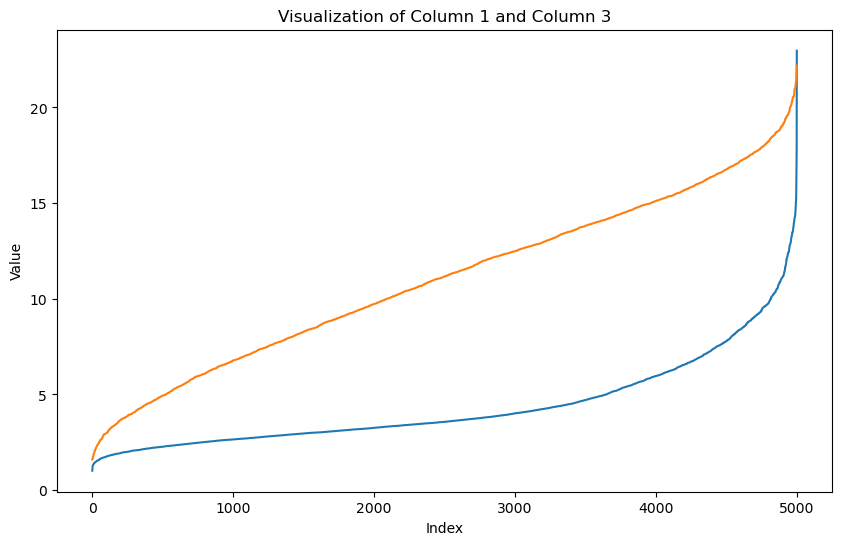

In [18]:
col_id_leg = [0]
# Selected epsilon: 0.1, 0.2, 0.3
col_id_adv = [1]
size_val=size_train=5000
x_train_CW2 = np.hstack([l1_dist_CW2_reduce[:size_train, col_id] for col_id in col_id_leg + col_id_adv])
y_train_CW2 = np.hstack([np.zeros(size_train * len(col_id_leg)), np.ones(size_train * len(col_id_adv))])

x_val_CW2 = np.hstack([l1_dist_CW2_reduce[-size_val:, col_id] for col_id in col_id_leg + col_id_adv])
y_val_CW2 = np.hstack([np.zeros(size_train * len(col_id_leg)), np.ones(size_train * len(col_id_adv))])
plt.figure(figsize=(10, 6)) 
x_CW2=sorted(list(x_train_CW2[:5000]))
x_CW2_adv=sorted(list(x_train_CW2[-5000:]))
plt.plot(x_CW2, label='adv')
plt.plot(x_CW2_adv, label='adv')

plt.title('Visualization of Column 1 and Column 3')
plt.xlabel('Index')  
plt.ylabel('Value')  

plt.show()

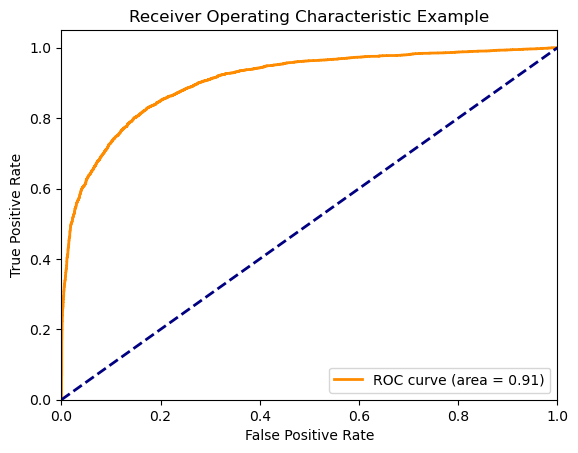

Best training accuracy: 0.8278,  检测率: 0.8280, 假阳率: 0.1722 阈值 @6.3390
ROC_AUC: 0.9064
Validation accuracy: 0.8212, 检测率: 0.8132, 假阳率: 0.1708 阈值 @6.3390
Validation ROC_AUC: 0.9023



In [19]:
train_detector(x_train_CW2, y_train_CW2, x_val_CW2, y_val_CW2)
print()